# Training Engineering and Model Assessment

Task: Perform a thorough analysis of training strategies and model assessment.

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import xarray as xr
import pandas as pd
import deep_snow.dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import os
from tqdm import tqdm

In [2]:
df = pd.read_parquet('/home/ayushg12/ML_GEO2024_ayushg12/mlgeo-2024-deep-snow/final_data/mlgeo-final-data/classic_ml_val_v1.parquet')
scaler = MinMaxScaler()
cols_to_normalize = [col for col in df.columns if col != 'aso_sd']
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
print("Length of dataset:", len(df))

Length of dataset: 5763835


In [3]:
df.head(5)

,aso_sd,snowon_vv,aerosol_optical_thickness,coastal_aerosol,blue,green,red,red_edge1,red_edge2,red_edge3,...,fcf,elevation,slope,aspect,curvature,tri,tpi,latitude,longitude,dowy
0,0.0,0.034741,0.451524,0.361875,0.353116,0.365153,0.375045,0.381241,0.439588,0.464821,...,0.25,0.444744,0.140537,0.827236,0.450719,0.124839,0.455258,0.785057,0.019264,0.056818
1,0.0,0.018444,0.451524,0.595530,0.752536,0.755720,0.760649,0.789616,0.806356,0.801144,...,0.22,0.446390,0.023371,0.905367,0.770828,0.138894,0.722182,0.785054,0.019303,0.056818
2,0.0,0.168401,0.451524,0.774610,0.882065,0.891728,0.898930,0.947582,0.970590,0.955312,...,0.27,0.444428,0.228046,0.230994,0.449177,0.195033,0.473952,0.785050,0.019342,0.056818
3,0.0,0.048596,0.451524,0.522883,0.694983,0.710806,0.722003,0.752439,0.792577,0.797974,...,0.29,0.441090,0.289067,0.203127,0.166511,0.294096,0.210729,0.785047,0.019382,0.056818
4,0.0,0.023445,0.451524,0.378733,0.435581,0.452939,0.464694,0.479667,0.541448,0.564868,...,0.29,0.439250,0.280976,0.165610,0.407580,0.260839,0.361191,0.785044,0.019421,0.056818


### Bootstrapping

In [24]:
# We define a random generator
np.random.seed(42)
rng = np.random.default_rng(seed=42)

# Sampling indices from df with replacements
nsubset = 1000000
subset = rng.choice(df.index, size=nsubset, replace=True)

y = df.iloc[subset, 0].values
data = df.iloc[subset, 1:].values

print(f"There are {data.shape[0]} data samples")
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.2, shuffle=True)

There are 1000000 data samples


In [25]:
# ElasticNet Regressor
en_reg = ElasticNet()
en_reg.fit(X_train, y_train) 
en_prediction = en_reg.predict(X_test)
print("ElasticNet Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=en_prediction))

# Ridge Regressor
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
ridge_prediction = ridge_reg.predict(X_test)
print("Ridge Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=ridge_prediction))

# Lasso Regressor
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
lasso_prediction = lasso_reg.predict(X_test)
print("Lasso Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=lasso_prediction))

# Dummy Regressor (Baseline)
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
dummy_prediction = dummy_reg.predict(X_test)
print("Dummy Regressor Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=dummy_prediction))

# Voting Regressor (Dummy and Ridge)
voting_reg = VotingRegressor(estimators=[('dummy', dummy_reg), ('ridge', ridge_reg)])
voting_reg.fit(X_train, y_train)
voting_prediction = voting_reg.predict(X_test)
print("Voting Regressor (Dummy + Ridge) Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=voting_prediction))

ElasticNet Mean Absolute Error: 0.6281584054644518
Ridge Mean Absolute Error: 0.4782230958538468
Lasso Mean Absolute Error: 0.6281584054644518
Dummy Regressor Mean Absolute Error: 0.46530253
Voting Regressor (Dummy + Ridge) Mean Absolute Error: 0.4402055597719834


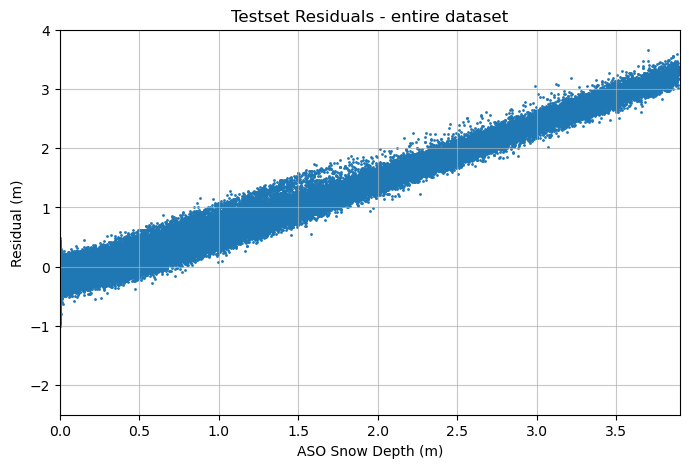

In [26]:
# Plotting the variations in residuals with the ground truth snow depth for Voting regression
residual_val = y_test - voting_prediction

fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.7);
plt.scatter(y_test, residual_val, s=1);
plt.xlabel('ASO Snow Depth (m)');
plt.ylabel('Residual (m)');
plt.title("Testset Residuals - entire dataset")
plt.ylim(-2.5, 4);
plt.xlim(0, 3.9);
plt.show()

### Bagging

In [27]:
# We define a random generator
np.random.seed(42)
rng = np.random.default_rng(seed=42)

# Sampling indices from df with replacements
nsubset = 1000000
subset = rng.choice(df.index, size=nsubset, replace=False)

y = df.iloc[subset, 0].values
data = df.iloc[subset, 1:].values

print(f"There are {data.shape[0]} data samples")
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.2, shuffle=True)

There are 1000000 data samples


In [28]:
# ElasticNet Regressor
en_reg = ElasticNet()
en_reg.fit(X_train, y_train) 
en_prediction = en_reg.predict(X_test)
print("ElasticNet Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=en_prediction))

# Ridge Regressor
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
ridge_prediction = ridge_reg.predict(X_test)
print("Ridge Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=ridge_prediction))

# Lasso Regressor
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
lasso_prediction = lasso_reg.predict(X_test)
print("Lasso Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=lasso_prediction))

# Dummy Regressor (Baseline)
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
dummy_prediction = dummy_reg.predict(X_test)
print("Dummy Regressor Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=dummy_prediction))

# Voting Regressor (Dummy and Ridge)
voting_reg = VotingRegressor(estimators=[('dummy', dummy_reg), ('ridge', ridge_reg)])
voting_reg.fit(X_train, y_train)
voting_prediction = voting_reg.predict(X_test)
print("Voting Regressor (Dummy + Ridge) Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=voting_prediction))

ElasticNet Mean Absolute Error: 0.6305250322628765
Ridge Mean Absolute Error: 0.48066481998202254
Lasso Mean Absolute Error: 0.6305250322628765
Dummy Regressor Mean Absolute Error: 0.47113332
Voting Regressor (Dummy + Ridge) Mean Absolute Error: 0.4443417974007433


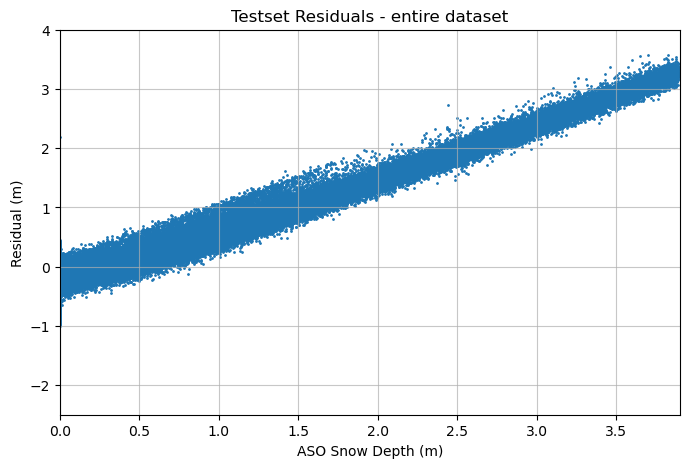

In [29]:
# Plotting the variations in residuals with the ground truth snow depth for Voting regression
residual_val = y_test - voting_prediction

fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.7);
plt.scatter(y_test, residual_val, s=1);
plt.xlabel('ASO Snow Depth (m)');
plt.ylabel('Residual (m)');
plt.title("Testset Residuals - entire dataset")
plt.ylim(-2.5, 4);
plt.xlim(0, 3.9);
plt.show()

### Dataset Augmentation Strategies

In [4]:
# Training the model using the entire dataset
# Split data into 80% train and 20% test subsets
y = df.iloc[:,0].values
data = df.iloc[:, 1:].values

print(f"There are {data.shape[0]} data samples")
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.2, shuffle=True)

There are 5763835 data samples


In [5]:
# let's see how these models do with cross validations
from sklearn.model_selection import cross_val_score

dummy_reg = DummyRegressor(strategy="median")
ridge_reg = Ridge(alpha=0.193, fit_intercept=True)

models = {
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Dummy": DummyRegressor(strategy="median"),
    "Voting": VotingRegressor(estimators=[('dummy', dummy_reg), ('ridge', ridge_reg)])
}

# evaluate each model with repeated cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', error_score='raise')
    print(f"{name} - Mean Absolute Error (5-fold CV): {np.mean(-scores):.4f} ± {np.std(-scores):.4f}")

ElasticNet - Mean Absolute Error (5-fold CV): 0.6300 ± 0.0003
Ridge - Mean Absolute Error (5-fold CV): 0.4803 ± 0.0003
Lasso - Mean Absolute Error (5-fold CV): 0.6300 ± 0.0003
Dummy - Mean Absolute Error (5-fold CV): 0.4688 ± 0.0003
Voting - Mean Absolute Error (5-fold CV): 0.4429 ± 0.0002


Mean Absolute Error for test set: 0.4426939416933109


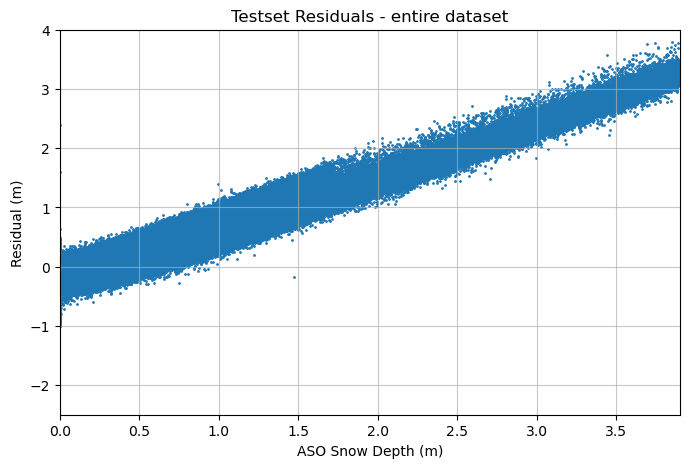

In [6]:
# As voting regression works the best amongst our other models
# Training voting regression model on training dataset
models['Voting'].fit(X_train, y_train)

# Testing the model on test split of dataset
y_test_pred = models['Voting'].predict(X_test)
print(f"Mean Absolute Error for test set: {metrics.mean_absolute_error(y_test, y_test_pred)}")

# Plotting the variations in residuals with the ground truth snow depth
residual_val = y_test - y_test_pred

fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.7);
plt.scatter(y_test, residual_val, s=1);
plt.xlabel('ASO Snow Depth (m)');
plt.ylabel('Residual (m)');
plt.title("Testset Residuals - entire dataset")
plt.ylim(-2.5, 4);
plt.xlim(0, 3.9);
plt.show()

In [7]:
# Out of the 5.7 million data samples, approx 3.2 million data points have snow depth = 0
# Removing zero snow depth points and trying to predict snow depth only for points that actually have snow
# Training the model only on regions with snow
df_filter = df[df['aso_sd']!=0]

y = df_filter.iloc[:,0].values
data = df_filter.iloc[:, 1:].values

print(f"There are {data.shape[0]} data samples")
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.2, shuffle=True)

There are 2498894 data samples


In [8]:
# let's see how these models do with cross validations
from sklearn.model_selection import cross_val_score

dummy_reg = DummyRegressor(strategy="median")
ridge_reg = Ridge(alpha=0.193, fit_intercept=True)

models = {
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Dummy": DummyRegressor(strategy="median"),
    "Voting": VotingRegressor(estimators=[('dummy', dummy_reg), ('ridge', ridge_reg)])
}

# evaluate each model with repeated cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', error_score='raise')
    print(f"{name} - Mean Absolute Error (5-fold CV): {np.mean(-scores):.4f} ± {np.std(-scores):.4f}")

ElasticNet - Mean Absolute Error (5-fold CV): 0.8344 ± 0.0005
Ridge - Mean Absolute Error (5-fold CV): 0.5619 ± 0.0005
Lasso - Mean Absolute Error (5-fold CV): 0.8344 ± 0.0005
Dummy - Mean Absolute Error (5-fold CV): 0.8002 ± 0.0010
Voting - Mean Absolute Error (5-fold CV): 0.6164 ± 0.0006


Mean Absolute Error for test set: 0.5602098808589618


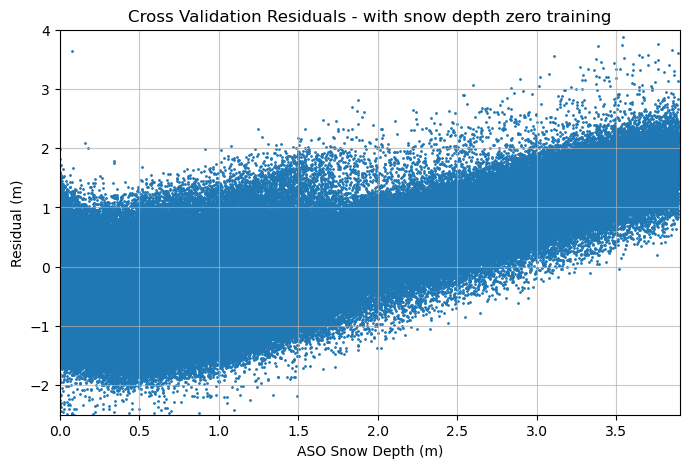

In [9]:
# As voting regression works the best amongst our other models
# Training voting regression model on training dataset
models['Ridge'].fit(X_train, y_train)

# Testing the model on test split of dataset
y_test_pred = models['Ridge'].predict(X_test)
print(f"Mean Absolute Error for test set: {metrics.mean_absolute_error(y_test, y_test_pred)}")

# Plotting the variations in residuals with the ground truth snow depth
residual_val = y_test - y_test_pred

fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.7);
plt.scatter(y_test, residual_val, s=1);
plt.xlabel('ASO Snow Depth (m)');
plt.ylabel('Residual (m)');
plt.title("Cross Validation Residuals - with snow depth zero training")
plt.ylim(-2.5, 4);
plt.xlim(0, 3.9);
plt.show()

The above plot shows that when we remove not snow regions there is reduction in residuals for the regions with higher ground truth snow depth.

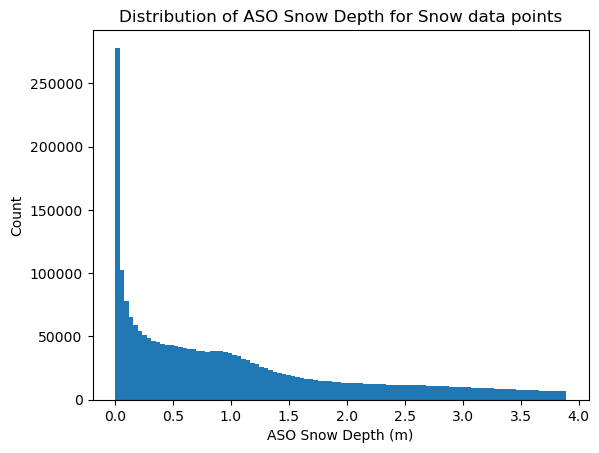

In [10]:
plt.hist(df_filter['aso_sd'], bins=100);
plt.xlabel('ASO Snow Depth (m)');
plt.ylabel('Count');
plt.title("Distribution of ASO Snow Depth for Snow data points")
plt.show()

In [11]:
# As observed above the distribution of snow depth data points varies and more points have lower snow depths
# We train the model by binning equal no. of elements from different ranges of snow depth
idx = []
idx_diff, bins_sz = 0.1, 25000
df_filter = df[df['aso_sd']!=0]
for x in np.arange(0, 3.9, idx_diff):
    ll = list(df_filter.index[(df_filter['aso_sd']>=x)&(df_filter['aso_sd']<x+idx_diff)])
    idx.extend(ll[:min(len(ll), bins_sz)])
    
random.shuffle(idx)
df_filter2 = df.iloc[idx]

y = df_filter2.iloc[:,0].values
data = df_filter2.iloc[:, 1:].values

print(f"There are {data.shape[0]} data samples")
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.2, shuffle=True)

There are 937894 data samples


In [12]:
# let's see how these models do with cross validations
from sklearn.model_selection import cross_val_score

dummy_reg = DummyRegressor(strategy="median")
ridge_reg = Ridge(alpha=0.193, fit_intercept=True)

models = {
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Dummy": DummyRegressor(strategy="median"),
    "Voting": VotingRegressor(estimators=[('dummy', dummy_reg), ('ridge', ridge_reg)])
}

# evaluate each model with repeated cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', error_score='raise')
    print(f"{name} - Mean Absolute Error (5-fold CV): {np.mean(-scores):.4f} ± {np.std(-scores):.4f}")

ElasticNet - Mean Absolute Error (5-fold CV): 0.9466 ± 0.0010
Ridge - Mean Absolute Error (5-fold CV): 0.5049 ± 0.0011
Lasso - Mean Absolute Error (5-fold CV): 0.9466 ± 0.0010
Dummy - Mean Absolute Error (5-fold CV): 0.9466 ± 0.0010
Voting - Mean Absolute Error (5-fold CV): 0.6679 ± 0.0008


Mean Absolute Error for test set: 0.504546863035537


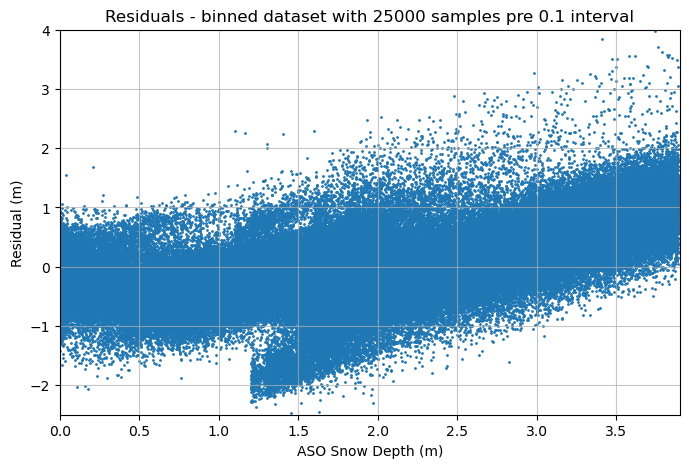

In [14]:
# As voting regression works the best amongst our other models
# Training voting regression model on training dataset
models['Ridge'].fit(X_train, y_train)

# Testing the model on test split of dataset
y_test_pred = models['Ridge'].predict(X_test)
print(f"Mean Absolute Error for test set: {metrics.mean_absolute_error(y_test, y_test_pred)}")

# Plotting the variations in residuals with the ground truth snow depth
residual_val = y_test - y_test_pred

fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.7);
plt.scatter(y_test, residual_val, s=1);
plt.xlabel('ASO Snow Depth (m)');
plt.ylabel('Residual (m)');
plt.title(f"Residuals - binned dataset with {bins_sz} samples pre {idx_diff} interval")
plt.ylim(-2.5, 4);
plt.xlim(0, 3.9);
plt.show()

Thus, when using a binned dataset 25000 samples pre 0.1 snow depth interval we are observing lower residuals for higher snow depths and Ridge regression provides highest as compared to other models.

We performed bootstrapping and bagging based resampling however they provides similar performance, however bootstrapping performed slightly better than bagging.

As shown from the cross-validation errors Voting regression shows performs the best when training on the entire dataset with a training and validation mean absolute errors of 0.4429 and 0.4427 respectively. However, it performs worse as the snow depth increases thus when we perform binning and pick 25000 samples for 0.1 snow depth intervals to make the distribution of snow depth more uniform. Ridge regression performs the best on this subset dataset with a mean absolute error of 0.5049 and 0.5045 for training and testing set respectively.

Moreover, we observed Dummy, Ridge and Voting regression performs the best and out of them Ridge regression had the highest standard deviation of cross-validation accuracies, while Voting regression had the lowest standard deviation. Thus Voting and Ridge regression had the highest and lowest generality respectively.